## Import dependencies

In [1]:
import os, inspect, sys
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from datetime import datetime
import matplotlib.pyplot as plt
# sqlalchemy dependencies
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import desc
from sqlalchemy import func
from sqlalchemy.sql import label

## Get project root directory

In [2]:
CURR_FILE = inspect.getabsfile(inspect.currentframe())
CURR_DIR = os.path.dirname(CURR_FILE)
ROOT_DIR = os.path.dirname(CURR_DIR)
sys.path.insert(0, ROOT_DIR)

## Set parameters

In [3]:
echo = False
plt.style.use('seaborn')
figsize = (13, 8)
label_fontsize = 17
title_fontsize = 20

## Create sqlite engine
Define database tools to connect, i.e. db API.

In [4]:
filename = os.path.join(ROOT_DIR, "surfpy", "data", "int", "hawaii.sqlite")
# filename = ":memory:"
engine = create_engine(f"sqlite:///{filename}", echo=echo)

## Reflect an existing database into a new model
Reflect an existing database into a new model

In [5]:
Base = automap_base()
Base.prepare(engine=engine, reflect=True)
# reflect the tables
Base.classes.keys()

['measurements', 'stations']

## Store tables
Save references to each table

In [6]:
Measurements = Base.classes.measurements
Stations = Base.classes.stations

## Create session
Wrap the database connectoin and transactions for the created engine. (gateway to our data)

In [7]:
session = Session(bind=engine)

## Precipitation Analysis

### Query to retrieve the last 12 months of precipitation data

In [8]:
years_before = 1
months_before = 0
days_before = 0
# get the most recent measurment acquired
recent_measurement = session.query(Measurements).order_by(desc(Measurements.date)).first()
measurement_end_date = recent_measurement.date
measurement_start_date = measurement_end_date - \
    relativedelta(years=years_before, months=months_before, days=days_before)

In [9]:
# query between start and end dates
query = (session.query(Measurements).filter(
    Measurements.date.between(measurement_start_date, measurement_end_date)))

In [10]:
# Save the query results as a Pandas DataFrame and set the index to the date column
query_df = pd.read_sql_query(query.statement, engine, index_col="date")
query_df.head()

,measurement_id,station,prcp,tobs
date,,,,
2016-08-23,2327,USC00519397,0.00,81.0
2016-08-24,2328,USC00519397,0.08,79.0
2016-08-25,2329,USC00519397,0.08,80.0
2016-08-26,2330,USC00519397,0.00,79.0
2016-08-27,2331,USC00519397,0.00,77.0


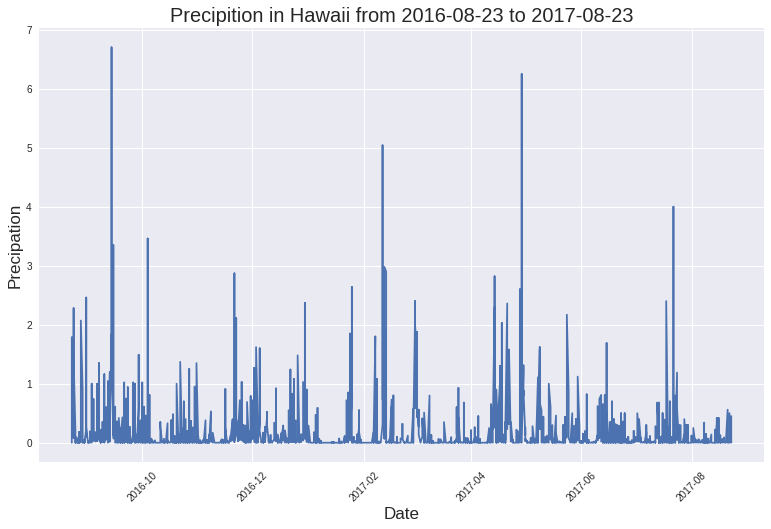

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
# Rotate the xticks for the dates
ax = query_df.plot(y="prcp",figsize = figsize, rot = 45, use_index = True, legend=False)
ax.set_ylabel('Precipation', fontsize=label_fontsize)
ax.set_xlabel('Date', fontsize=label_fontsize)
plt.title("Precipition in Hawaii from %s to %s" % (query_df.index.min(), query_df.index.max()),
         fontsize=title_fontsize)
plt.show()

### Percipitation summary statistics

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
query_df[["prcp"]].describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

### Number of sations

In [13]:
# How many stations are available in this dataset?
n_stations = session.query(Stations).group_by(Stations.station).count()
print(f"Number of available stations: {n_stations}")

Number of available stations: 9


### Station activities

In [14]:
# What are the most active stations?
# List the stations and the counts in descending order.
query = session.query(
    Measurements.station, label("activity", func.count(Measurements.station))).filter(
        Stations.station == Measurements.station)
query = query.group_by(Measurements.station)
query = query.order_by(desc("activity"))


In [15]:
query.all()

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

### Most active station

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = query[0][0]
query = session.query(
    Measurements.station,
    label("min_tobs", func.min(Measurements.tobs)),
    label("max_tobs", func.max(Measurements.tobs)),
    label("avg_tobs", func.avg(Measurements.tobs))).filter(
        most_active_station == Measurements.station)


In [17]:
query.all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

### Last year temperature observation data

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
query = session.query(
    Measurements.tobs).filter(
        most_active_station == Measurements.station,
        Measurements.date.between(measurement_start_date, measurement_end_date))

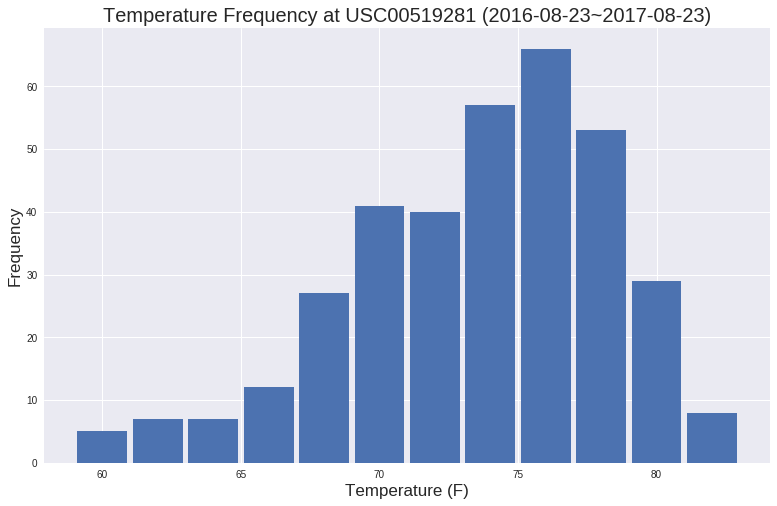

In [19]:
# plot the results as a histogram
tobs = [elem[0] for elem in query]
fig = plt.figure(figsize=figsize)
ax = fig.subplots(ncols=1, nrows=1)
ax.hist(tobs, bins=12, rwidth=0.9)
ax.set_xlabel("Temperature (F)", fontsize=label_fontsize)
ax.set_ylabel("Frequency", fontsize=label_fontsize)
_ = ax.set_title(f"Temperature Frequency at {most_active_station} ({measurement_start_date}~{measurement_end_date})", fontsize=title_fontsize)

### Temperature helper function

In [20]:
# helper function to calculate temperature stats over given range
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    start_date_ = datetime.strptime(start_date, "%Y-%m-%d")
    end_date_ = datetime.strptime(end_date, "%Y-%m-%d")
    query = session.query(func.min(Measurements.tobs),
                        func.avg(Measurements.tobs),
                        func.max(Measurements.tobs)).filter(
        Measurements.date >= start_date_, Measurements.date <= end_date_).all()
    return query[0]
print(calc_temps('2012-02-28', '2012-03-05'))

(62.0, 69.20930232558139, 74.0)


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# calc temperature data
trip_start_date = '2017-01-28'
trip_end_date = '2017-03-05'
tobs_min, tobs_avg, tobs_max = calc_temps(trip_start_date, trip_end_date)

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

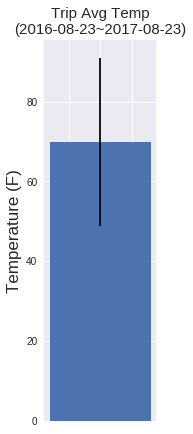

In [23]:
fig = plt.figure(figsize=(2,7))
ax = fig.subplots(ncols=1, nrows=1)
ax.bar(x=1, height=tobs_avg, yerr=(tobs_max-tobs_min))
ax.set_xticklabels("")
ax.set_ylabel("Temperature (F)", fontsize=label_fontsize)
_ = ax.set_title("Trip Avg Temp" + os.linesep +f"({measurement_start_date}~{measurement_end_date})",
                 fontsize=15)

In [24]:
# helper function to calculate precipitation over given range
def calc_prcp(start_date, end_date):
    """STATION_ID, STATION_NAME, LATITUDE, LONGITUDE, PRECIPITATION for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        [(STATION_ID, STATION_NAME, LATITUDE, LONGITUDE, PRECIPITATION),
         ....,
        ]
    """
    start_date_ = datetime.strptime(start_date, "%Y-%m-%d")
    end_date_ = datetime.strptime(end_date, "%Y-%m-%d")
    query = session.query(
        Measurements.station,
        Stations.name,
        Stations.latitude,
        Stations.longitude,
        Stations.elevation,
        label("sumprcp", func.sum(Measurements.prcp))).filter(
            Measurements.date >= start_date_, Measurements.date <= end_date_).filter(
                Measurements.station == Stations.station)
    query = query.group_by(Measurements.station)
    query = query.order_by(desc("sumprcp"))
    return query.all()

In [25]:
trip_start_date = '2017-01-01'
trip_end_date = '2017-01-05'
print(calc_prcp(trip_start_date, trip_end_date))

[('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.6), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.47), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999995, 32.9, 0.06999999999999999), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.01), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)]


### Other recommended analysis

In [26]:
# helper function to calculate daily precipitation
def dailu_prcp(date):
    pass

# helper function to calculate daily normals
def daily_normals(date):
    """Daily Normals.
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [label("mintobs", func.min(Measurements.tobs)),
           label("avgtobs", func.avg(Measurements.tobs)),
           label("maxtobs", func.max(Measurements.tobs))]
    query = session.query(*sel).filter(
        func.strftime("%m-%d", Measurements.date) == date)
    return query.all()[0]
    
# helper function to create range of date within given range
def date_range(start, end, step=1, format=None):
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    step = relativedelta(days=step)

    range_date = []
    while start <= end:
        if format is not None:
            range_date.append(start.strftime(format))
        else:
            range_date.append(start)
        start += step
    return range_date

In [27]:
# Set the start and end date of the trip
start_date = '2017-01-01'
end_date = '2017-01-15'

# Use the start and end date to create a range of dates
dates = date_range(start=start_date, end=end_date, step=1, format="%m-%d")

trip_daily_normals = []
for date in dates:
    trip_daily_normals.append(daily_normals(date=date))

trip_daily_normals

[(62.0, 69.06, 77.0),
 (60.0, 69.40816326530613, 77.0),
 (62.0, 68.83333333333333, 77.0),
 (58.0, 69.83636363636364, 76.0),
 (56.0, 68.0, 76.0),
 (61.0, 68.88679245283019, 76.0),
 (57.0, 68.38181818181818, 76.0),
 (57.0, 67.2, 75.0),
 (58.0, 68.07272727272728, 78.0),
 (62.0, 69.81132075471699, 77.0),
 (57.0, 67.07843137254902, 78.0),
 (57.0, 67.12, 80.0),
 (57.0, 66.68085106382979, 77.0),
 (58.0, 69.42592592592592, 77.0),
 (56.0, 68.95833333333333, 76.0)]

In [28]:
# load daily normals into a Pandas DataFrame
index = date_range(trip_start_date, trip_end_date)
df_dailynormals = pd.DataFrame(index=index, data=trip_daily_normals)
df_dailynormals.index.name = "date"
df_dailynormals


,mintobs,avgtobs,maxtobs
date,,,
2017-01-01,62.0,69.060000,77.0
2017-01-02,60.0,69.408163,77.0
2017-01-03,62.0,68.833333,77.0
2017-01-04,58.0,69.836364,76.0
2017-01-05,56.0,68.000000,76.0
2017-01-06,61.0,68.886792,76.0
2017-01-07,57.0,68.381818,76.0
2017-01-08,57.0,67.200000,75.0
2017-01-09,58.0,68.072727,78.0


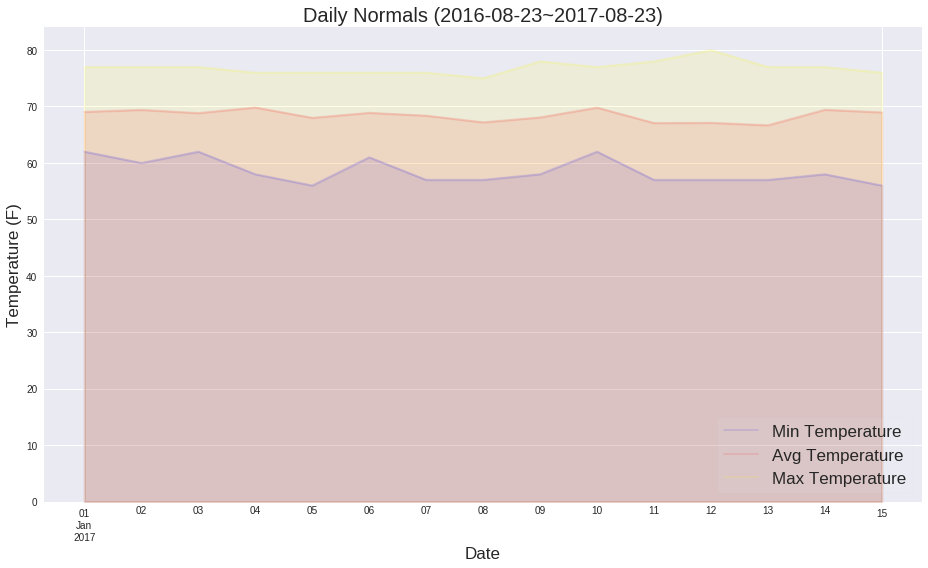

In [29]:
# Plot the daily normals as an area plot with `stacked=False`
ax = df_dailynormals.plot(
    kind="area",
    stacked=False,
    color=["blue", "red", "yellow"],
    lw=2,
    alpha=0.1,
    rot=0,
    figsize=figsize)
# ax.set_xticks(np.arange(0, len(df_dailynormals.index), 1))
# ax.set_xticklabels(df_dailynormals.index.values)
ax.set_xlabel("Date", fontsize=label_fontsize)
ax.set_ylabel("Temperature (F)", fontsize=label_fontsize)
_ = ax.set_title(f"Daily Normals ({measurement_start_date}~{measurement_end_date})",
                 fontsize=title_fontsize)
_ = ax.legend(labels=["Min Temperature", "Avg Temperature", "Max Temperature"],
              loc="lower right",
              fontsize=label_fontsize,
              markerscale=2,
              frameon=True,
              framealpha=0.1,
         )
plt.tight_layout()

In [30]:
date = "01-01"
query = session.query(Measurements.station, Measurements.date, Measurements.prcp).filter(
    func.strftime("%m-%d", Measurements.date) == date, Measurements.station == Stations.station)
# query = query.group_by(Measurements.station)
query.all()


[('USC00519397', datetime.date(2010, 1, 1), 0.08),
 ('USC00519397', datetime.date(2011, 1, 1), 0.0),
 ('USC00519397', datetime.date(2012, 1, 1), 0.0),
 ('USC00519397', datetime.date(2013, 1, 1), 0.02),
 ('USC00519397', datetime.date(2014, 1, 1), 0.0),
 ('USC00519397', datetime.date(2015, 1, 1), 0.0),
 ('USC00519397', datetime.date(2016, 1, 1), 0.0),
 ('USC00519397', datetime.date(2017, 1, 1), 0.0),
 ('USC00513117', datetime.date(2010, 1, 1), 0.28),
 ('USC00513117', datetime.date(2011, 1, 1), 0.42),
 ('USC00513117', datetime.date(2012, 1, 1), 0.01),
 ('USC00513117', datetime.date(2013, 1, 1), 0.16),
 ('USC00513117', datetime.date(2014, 1, 1), 0.0),
 ('USC00513117', datetime.date(2015, 1, 1), 0.01),
 ('USC00513117', datetime.date(2016, 1, 1), 0.02),
 ('USC00513117', datetime.date(2017, 1, 1), 0.29),
 ('USC00514830', datetime.date(2011, 1, 1), 0.14),
 ('USC00514830', datetime.date(2012, 1, 1), 0.0),
 ('USC00514830', datetime.date(2015, 1, 1), 0.0),
 ('USC00514830', datetime.date(2016, 1, 